In [9]:
import shutil
from pathlib import Path
import asyncio
from functools import wraps, partial

def async_wrap(func):
    @wraps(func)
    async def run(*args, loop=None, executor=None, **kwargs):
        if loop is None:
            loop = asyncio.get_event_loop()
        pfunc = partial(func, *args, **kwargs)
        return await loop.run_in_executor(executor, pfunc)
    return run

from asreview import ASReviewData, ASReviewProject
from asreview.review import ReviewSimulate
from asreview.project import ProjectExistsError

from asreview.models.classifiers import (
  LogisticClassifier,
  NaiveBayesClassifier,
  NN2LayerClassifier,
  RandomForestClassifier,
  SVMClassifier
)
from asreview.models.query import MaxQuery
from asreview.models.balance import DoubleBalance
from asreview.models.feature_extraction import (
  Tfidf,
  Doc2Vec
)

async def simulate_project(
    name,
    data_filename,
    classifier_model,
    feature_extraction_model,
    query_model=MaxQuery,
    balance_model=DoubleBalance
  ):
  project_path = Path("projects", name)
  project_path.mkdir(exist_ok=True)

  try:
    project = ASReviewProject.create(
      project_path=project_path / "simulation",
      project_id=name,
      project_mode="simulate",
      project_name=name,
    )
  except ProjectExistsError:
    shutil.rmtree(project_path)
    project = ASReviewProject.create(
      project_path=project_path / "simulation",
      project_id=name,
      project_mode="simulate",
      project_name=name,
    )

  print(f"{name}: Project Created")

  data_obj = ASReviewData.from_file(
    Path("data", data_filename)
  )

  async_review_simulate = async_wrap(ReviewSimulate)
  reviewer = await async_review_simulate(
    as_data=data_obj,
    model=classifier_model(),
    query_model=query_model(),
    balance_model=balance_model(),
    feature_model=feature_extraction_model(),
    n_instances=1,
    project=project,
    n_prior_included=10,
    n_prior_excluded=10,
    stop_if='min'
  )

  print(f"{name}: ReviewSimulate object Created")

  project.update_review(status="review")
  print(f"{name}: Review start")
  try:
      async_start_review = async_wrap(reviewer.review)
      await async_start_review()
  except Exception as err:
      project.update_review(status="error")
      print(f"{name}: Review error: {err}")
  print(f"{name}: Review end")

  project.export(Path("states", f"{name}.asreview"))
  print(f"{name}: Review exported")

In [17]:
await simulate_project("B_L_D", "brouwer_et_al.csv", LogisticClassifier, Doc2Vec)

B_L_D: Project Created


/Users/jahnsmichael/Projects/IR ASReview/env/lib/python3.12/site-packages/asreview/io/utils.py:142: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(LABEL_NA, inplace=True)


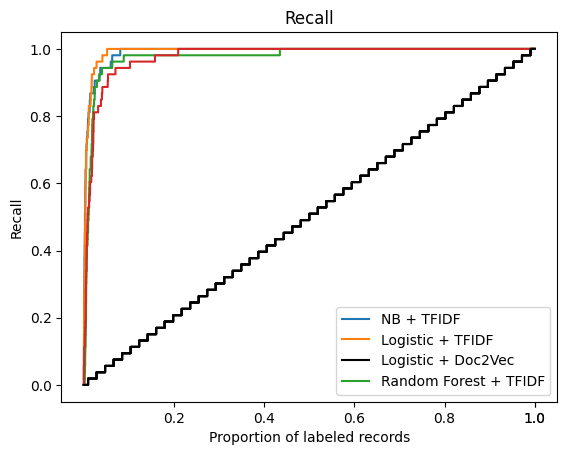

In [7]:
import matplotlib.pyplot as plt

from asreview import open_state
from asreviewcontrib.insights.plot import plot_recall

fig, ax = plt.subplots()

with open_state("states/B_NB_T.asreview") as s1:
  plot_recall(ax, s1)

with open_state("states/B_L_T.asreview") as s2:
  plot_recall(ax, s2)

with open_state("states/B_L_D.asreview") as s3:
  plot_recall(ax, s3)

with open_state("states/B_RF_T.asreview") as s4:
  plot_recall(ax, s4)

ax.lines[0].set_label("NB + TFIDF")
ax.lines[2].set_label("Logistic + TFIDF")
ax.lines[3].set_label("Logistic + Doc2Vec")
ax.lines[4].set_label("Random Forest + TFIDF")
ax.legend()

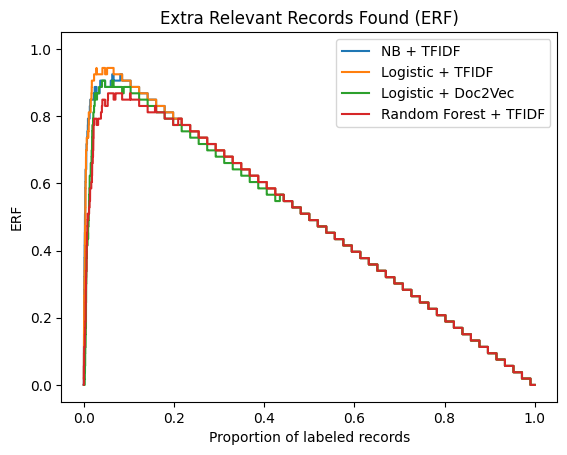

In [6]:
import matplotlib.pyplot as plt

from asreview import open_state
from asreviewcontrib.insights.plot import plot_erf

fig, ax = plt.subplots()

with open_state("states/B_NB_T.asreview") as s1:
  plot_erf(ax, s1)

with open_state("states/B_L_T.asreview") as s2:
  plot_erf(ax, s2)

with open_state("states/B_L_D.asreview") as s3:
  plot_erf(ax, s3)

with open_state("states/B_RF_T.asreview") as s4:
  plot_erf(ax, s4)

ax.lines[0].set_label("NB + TFIDF")
ax.lines[1].set_label("Logistic + TFIDF")
ax.lines[2].set_label("Logistic + Doc2Vec")
ax.lines[3].set_label("Random Forest + TFIDF")
ax.legend()

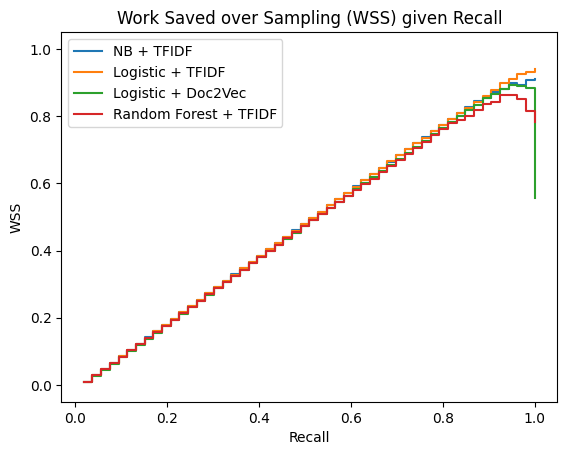

In [8]:
import matplotlib.pyplot as plt

from asreview import open_state
from asreviewcontrib.insights.plot import plot_wss

fig, ax = plt.subplots()

with open_state("states/B_NB_T.asreview") as s1:
  plot_wss(ax, s1)

with open_state("states/B_L_T.asreview") as s2:
  plot_wss(ax, s2)

with open_state("states/B_L_D.asreview") as s3:
  plot_wss(ax, s3)

with open_state("states/B_RF_T.asreview") as s4:
  plot_wss(ax, s4)

ax.lines[0].set_label("NB + TFIDF")
ax.lines[1].set_label("Logistic + TFIDF")
ax.lines[2].set_label("Logistic + Doc2Vec")
ax.lines[3].set_label("Random Forest + TFIDF")
ax.legend()

In [16]:
import pandas as pd
from asreviewcontrib.insights.metrics import wss, erf, average_time_to_discovery
from asreview import open_state

def print_all_metrics(s):
  df = s.get_dataset()
  mit = pd.to_datetime(df.labeling_time.sort_values(ascending=True).unique()).to_series().diff().median().total_seconds() * 1000
  print(f'WSS@95: {wss(s, 0.95)}')
  print(f'MIT: {mit} ms')
  print(f'ATD: {average_time_to_discovery(s)}')
  print(f'RRF@10: {erf(s, 0.1)}')
  print()

with open_state("states/B_NB_T.asreview") as s:
  print("[NB + TFIDF]")
  print_all_metrics(s)

with open_state("states/B_L_T.asreview") as s:
  print("[Logistic + TFIDF]")
  print_all_metrics(s)

with open_state("states/B_L_D.asreview") as s:
  print("[Logistic + Doc2Vec]")
  print_all_metrics(s)

with open_state("states/B_RF_T.asreview") as s:
  print("[RF + TFIDF]")
  print_all_metrics(s)


[NB + TFIDF]
WSS@95: 0.897812580895677
MIT: 42.915 ms
ATD: 381.58490566037733
RRF@10: 0.9056603773584906

[Logistic + TFIDF]
WSS@95: 0.9139485719216498
MIT: 194.689 ms
ATD: 301.9056603773585
RRF@10: 0.9056603773584906

[Logistic + Doc2Vec]
WSS@95: 0.911165760635085
MIT: 199.155 ms
ATD: 295.5660377358491
RRF@10: 0.9056603773584906

[RF + TFIDF]
WSS@95: 0.8637716800414186
MIT: 3920.985 ms
ATD: 1043.0377358490566
RRF@10: 0.8490566037735849

